Problem statement:
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
Predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams!

Data Dictionary:

Id - an Id that represents a (Store, Date) duple within the test set
Store - a unique Id for each store
Sales - the turnover for any given day (this is what you are predicting)
Customers - the number of customers on a given day
Open - an indicator for whether the store was open: 0 = closed, 1 = open
StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
StoreType - differentiates between 4 different store models: a, b, c, d
Assortment - describes an assortment level: a = basic, b = extra, c = extended
CompetitionDistance - distance in meters to the nearest competitor store
CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
Promo - indicates whether a store is running a promo on that day
Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

Time Series Problem

In [1]:
import pandas as pd

Reading and Understanding Data

In [2]:
store = pd.read_csv("/content/rossmann_store/store.csv")
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [3]:
train = pd.read_csv("/content/rossmann_store/train.csv")
train

/tmp/ipython-input-3-103868220.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("/content/rossmann_store/train.csv")


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [4]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [5]:
store['CompetitionOpenSinceMonth'].unique().tolist()

[9.0, 11.0, 12.0, 4.0, 10.0, 8.0, nan, 3.0, 6.0, 5.0, 1.0, 2.0, 7.0]

In [6]:
store['Promo2SinceWeek'].unique().tolist()

[nan,
 13.0,
 14.0,
 1.0,
 45.0,
 40.0,
 26.0,
 22.0,
 5.0,
 6.0,
 10.0,
 31.0,
 37.0,
 9.0,
 39.0,
 27.0,
 18.0,
 35.0,
 23.0,
 48.0,
 36.0,
 50.0,
 44.0,
 49.0,
 28.0]

Preprocessing Data

In [7]:
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].fillna(0.0)
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].fillna(0.0)

In [8]:
store['CompetitionOpenSinceMonth'].isnull().sum() ## Feature

np.int64(0)

In [9]:
store['Promo2SinceWeek'].isnull().sum() ## feature

np.int64(0)

In [10]:
train['Date'].isnull().sum() ## Feature

np.int64(0)

In [11]:
train['DayOfWeek'].isnull().sum() ## feature

np.int64(0)

In [12]:
train['Sales'].isnull().sum() ### target var

np.int64(0)

In [13]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [14]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [15]:
df = train.merge(store, on="Store")
df.shape

(1017209, 18)

In [16]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,NaN,NaN


In [17]:
df['Open'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

,proportion
Open,
1,83.0%
0,17.0%


In [18]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

EDA

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

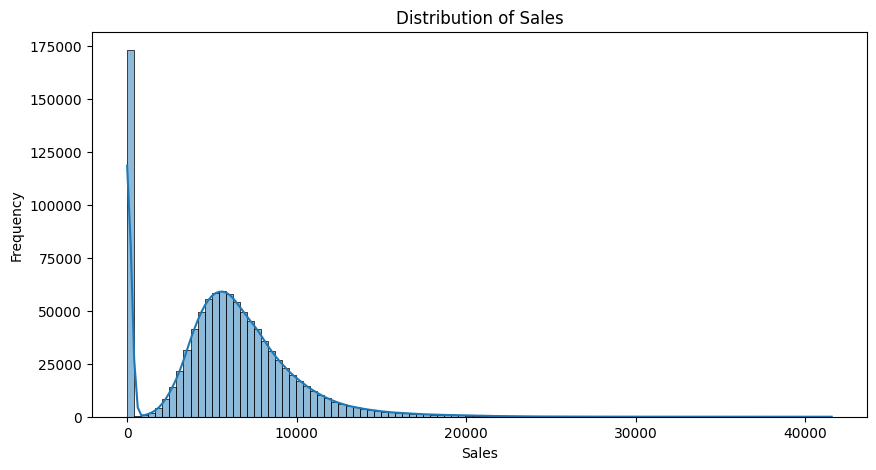

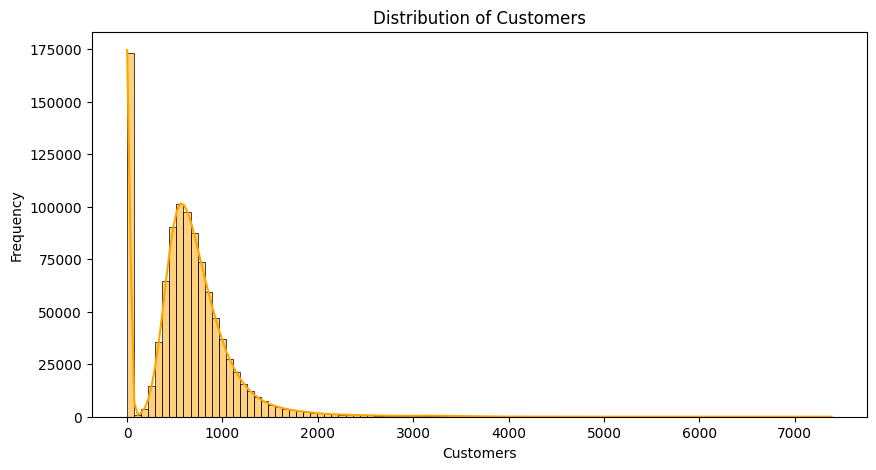

In [20]:
# Distribution of Sales
plt.figure(figsize=(10, 5))
sns.histplot(df['Sales'], bins=100, kde=True)
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

# Distribution of Customers
plt.figure(figsize=(10, 5))
sns.histplot(df['Customers'], bins=100, kde=True, color='orange')
plt.title("Distribution of Customers")
plt.xlabel("Customers")
plt.ylabel("Frequency")
plt.show()

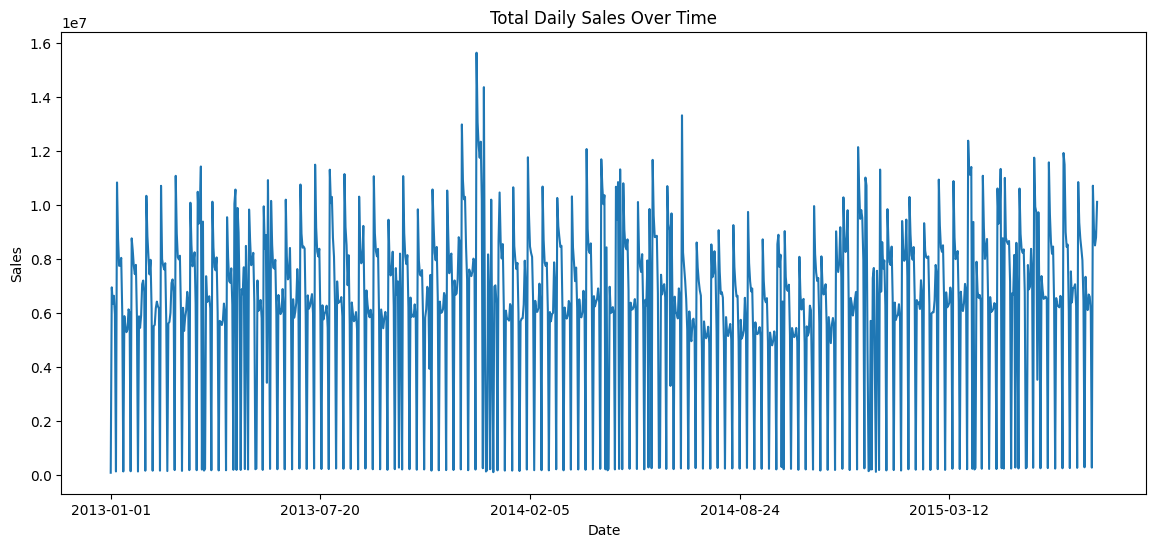

In [21]:
# Aggregate daily sales
daily_sales = df.groupby('Date')['Sales'].sum()

plt.figure(figsize=(14, 6))
daily_sales.plot()
plt.title("Total Daily Sales Over Time")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.show()


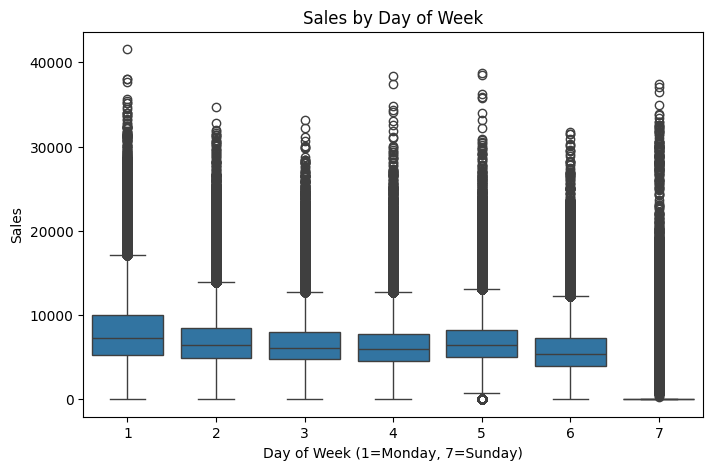

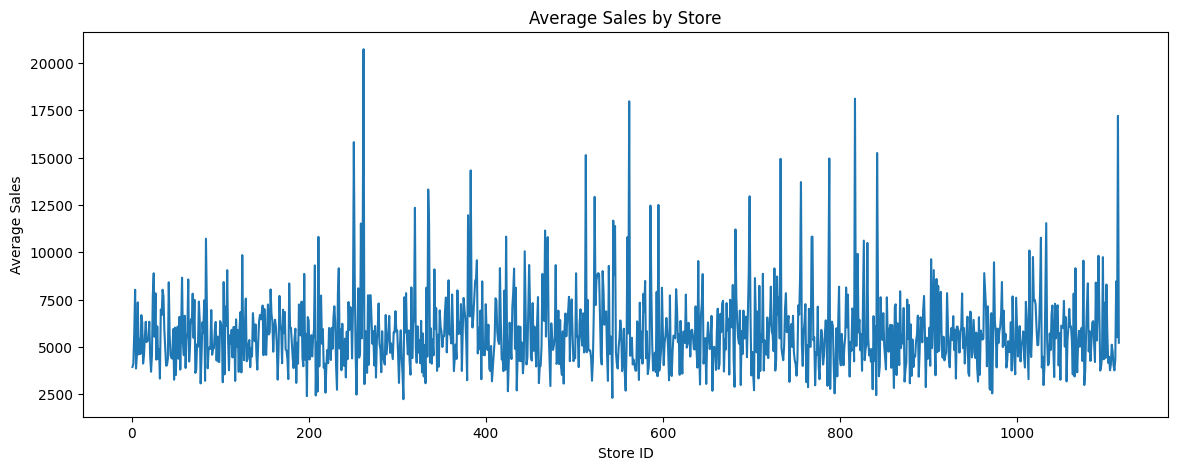

In [22]:
# Sales by Day of Week
plt.figure(figsize=(8, 5))
sns.boxplot(x='DayOfWeek', y='Sales', data=df)
plt.title("Sales by Day of Week")
plt.xlabel("Day of Week (1=Monday, 7=Sunday)")
plt.ylabel("Sales")
plt.show()

# Sales by Store
store_sales = df.groupby('Store')['Sales'].mean()
plt.figure(figsize=(14, 5))
store_sales.plot()
plt.title("Average Sales by Store")
plt.ylabel("Average Sales")
plt.xlabel("Store ID")
plt.show()


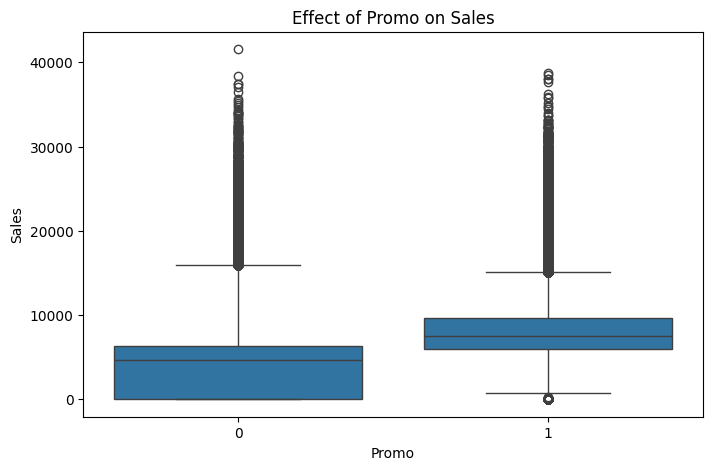

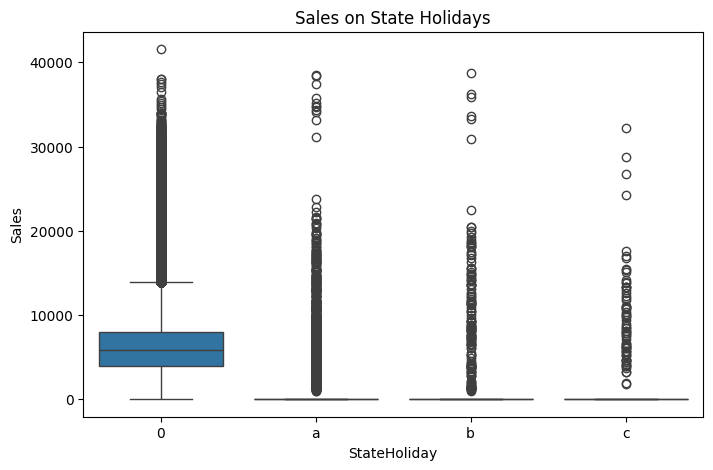

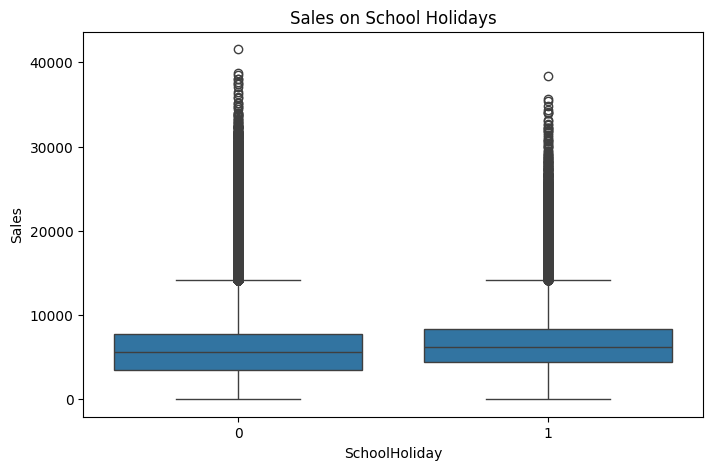

In [23]:
# Sales with/without Promo
plt.figure(figsize=(8, 5))
sns.boxplot(x='Promo', y='Sales', data=df)
plt.title("Effect of Promo on Sales")
plt.show()

# Sales by State Holiday
plt.figure(figsize=(8, 5))
sns.boxplot(x='StateHoliday', y='Sales', data=df)
plt.title("Sales on State Holidays")
plt.show()

# Sales on School Holidays
plt.figure(figsize=(8, 5))
sns.boxplot(x='SchoolHoliday', y='Sales', data=df)
plt.title("Sales on School Holidays")
plt.show()


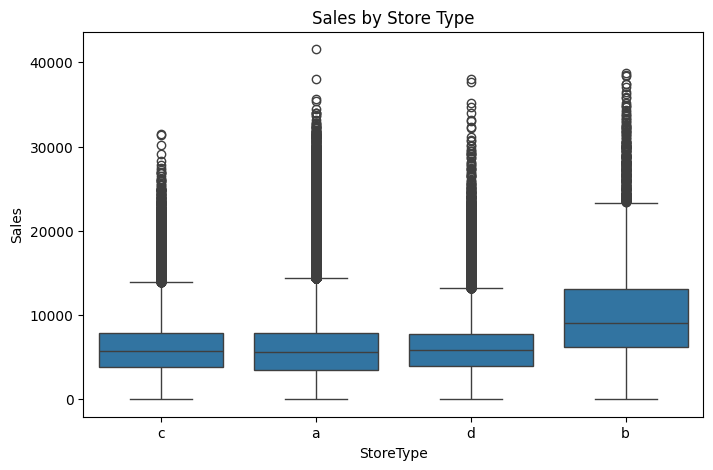

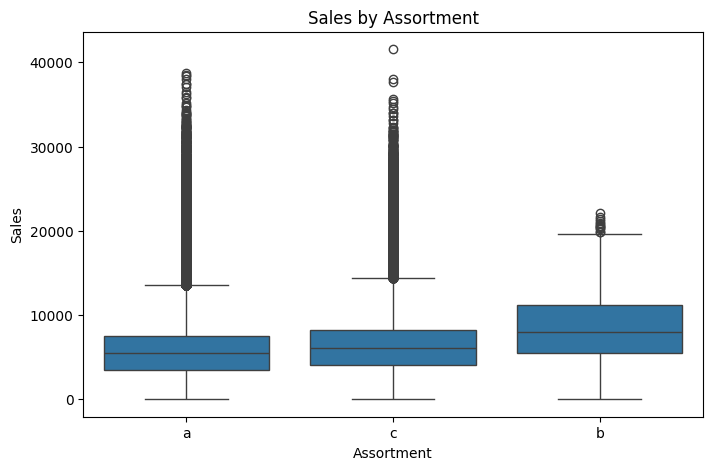

In [24]:
# Sales by Store Type
plt.figure(figsize=(8, 5))
sns.boxplot(x='StoreType', y='Sales', data=df)
plt.title("Sales by Store Type")
plt.show()

# Sales by Assortment
plt.figure(figsize=(8, 5))
sns.boxplot(x='Assortment', y='Sales', data=df)
plt.title("Sales by Assortment")
plt.show()


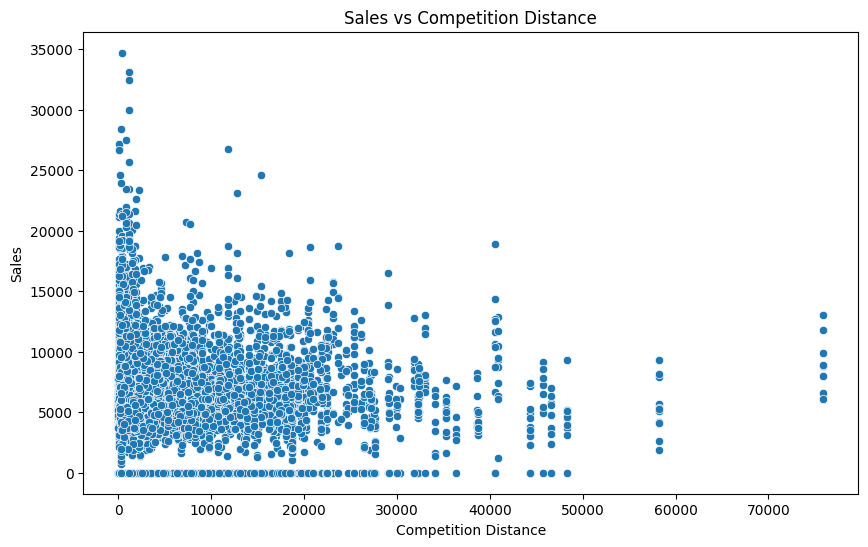

In [25]:
# Competition Distance vs Sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=df.sample(10000))
plt.title("Sales vs Competition Distance")
plt.xlabel("Competition Distance")
plt.ylabel("Sales")
plt.show()


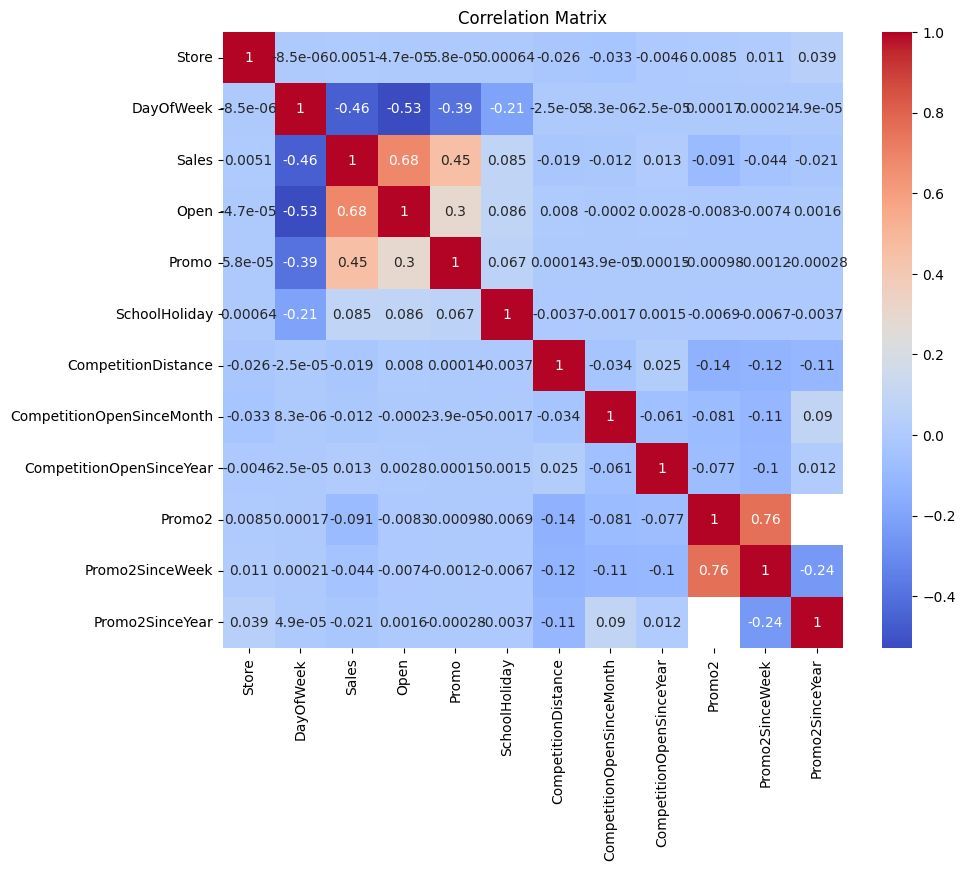

In [26]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).drop(['Customers'], axis=1)

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Feature Selection

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  1017209 non-null  float64
 13  CompetitionO

In [28]:
import datetime as dt

In [29]:
df['Date'] = pd.to_datetime(df['Date'])

In [30]:
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [31]:
df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [32]:
df['StateHoliday'] = df['StateHoliday'].replace(0,'0')

In [33]:
df = pd.get_dummies(df, columns=['StateHoliday'], drop_first=True)

In [34]:
df = df[df['Open']==1]

In [35]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Day,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,5,2015-07-31,5263,555,1,1,1,c,a,...,2008.0,0,0.0,NaN,NaN,7,31,False,False,False
1,2,5,2015-07-31,6064,625,1,1,1,a,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",7,31,False,False,False
2,3,5,2015-07-31,8314,821,1,1,1,a,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7,31,False,False,False
3,4,5,2015-07-31,13995,1498,1,1,1,c,c,...,2009.0,0,0.0,NaN,NaN,7,31,False,False,False
4,5,5,2015-07-31,4822,559,1,1,1,a,a,...,2015.0,0,0.0,NaN,NaN,7,31,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,1,b,a,...,2006.0,0,0.0,NaN,NaN,1,1,True,False,False
1016827,733,2,2013-01-01,10765,2377,1,0,1,b,b,...,1999.0,0,0.0,NaN,NaN,1,1,True,False,False
1016863,769,2,2013-01-01,5035,1248,1,0,1,b,b,...,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",1,1,True,False,False
1017042,948,2,2013-01-01,4491,1039,1,0,1,b,b,...,NaN,0,0.0,NaN,NaN,1,1,True,False,False


In [36]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Month', 'Day',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'],
      dtype='object')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844392 entries, 0 to 1017190
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   SchoolHoliday              844392 non-null  int64         
 8   StoreType                  844392 non-null  object        
 9   Assortment                 844392 non-null  object        
 10  CompetitionDistance        842206 non-null  float64       
 11  CompetitionOpenSinceMonth  844392 non-null  float64     

In [38]:
df['Day']

,Day
0,31
1,31
2,31
3,31
4,31
...,...
1016776,1
1016827,1
1016863,1
1017042,1


In [39]:
features = ['Open','SchoolHoliday','DayOfWeek','Month','Day','CompetitionDistance']

In [40]:
stateholiday = [col for col in df.columns if "StateHoliday_" in col]

In [41]:
stateholiday

['StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']

In [42]:
features = features + stateholiday

In [43]:
features

['Open',
 'SchoolHoliday',
 'DayOfWeek',
 'Month',
 'Day',
 'CompetitionDistance',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c']

Train and Test data split

In [44]:
X = df[features]
y = df['Sales']

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [47]:
X_train

,Open,SchoolHoliday,DayOfWeek,Month,Day,CompetitionDistance,StateHoliday_a,StateHoliday_b,StateHoliday_c
947192,1,0,1,3,4,10800.0,False,False,False
512268,1,0,6,3,29,16420.0,False,False,False
1008918,1,0,2,1,8,510.0,False,False,False
521587,1,0,5,3,21,3040.0,False,False,False
836684,1,0,2,6,11,6190.0,False,False,False
...,...,...,...,...,...,...,...,...,...
312959,1,0,6,10,11,30.0,False,False,False
439627,1,0,2,6,3,1340.0,False,False,False
159818,1,0,2,3,10,1150.0,False,False,False
806510,1,0,1,7,8,540.0,False,False,False


Model Building

In [48]:
import xgboost as xgb

In [49]:
xgb = xgb.XGBRegressor(
    n_estimators = 100,
    max_depth = 10,
    random_state = 42,
    learning_rate = 0.1
)

In [50]:
xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [51]:
from sklearn.metrics import mean_squared_log_error

In [52]:
# pip install --upgrade scikit-learn

In [53]:
# Predict & evaluate
preds = xgb.predict(X_test)
rmsle = mean_squared_log_error(y_test, preds, squared=False)
print(f"RMSLE: {rmsle:.4f}")

TypeError: got an unexpected keyword argument 'squared'

In [55]:
# Manually Predict the rmse value

import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Apply only on non-zero targets to avoid log(0)
rmsle_score = rmsle(y_test, preds)
print(f"RMSLE: {rmsle_score:.2f}")

RMSLE: 0.34


Feature Importance

<Axes: >

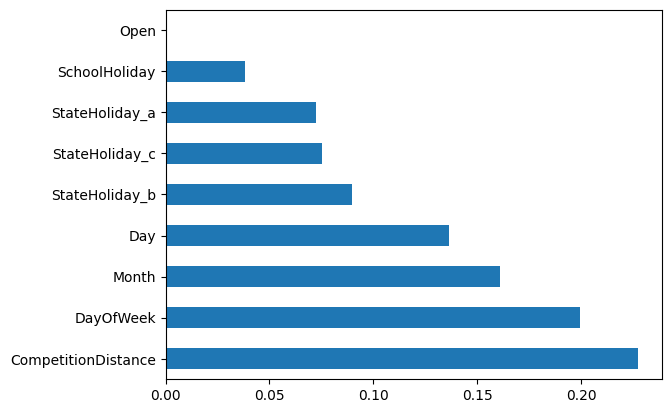

In [56]:
importance = pd.Series(xgb.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).plot(kind='barh')